# Week 4 Day 2

## MNIST GAN

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/defreez/cs356-notebooks/blob/main/notebooks/mnist-gan.ipynb)

This notebook is based on [Thomas Jacob's Kaggle Notebook](https://www.kaggle.com/tjac718/dcgan-on-mnist-dataset-using-pytorch)

- Only DCGAN version
- Switched dropout layers back to batch normalization
- BCELoss with Sigmoid instead of BCEWithLogit
- Use built-in torchvision dataloaders

Nice high-level overview of GANs

https://developers.google.com/machine-learning/gan/gan_structure

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import torch.optim as optim

In [2]:
# All datasets and networks are transferred to device
# If a GPU is available this is a GPU. If not, it is the CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Normalize images to [-1, 1]
# Use this normalizatin for 1 channel.
# For 3 channel normalization (color) look at the PyTorch DCGAN notebook
# image = (image - mean) / std
# So 0 becomes 0 - 0.5 / 0.5 (-1)
# 1 becomes 1 - 0.5 / 0.5 (1)
transform = transforms.Compose([transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [4]:
batch_size = 64
dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
def z_noise(batch_size, dim):
    return torch.rand(batch_size, dim)*2 - 1

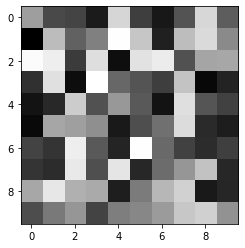

In [6]:
a = z_noise(64, 100)
b = a[2]
b = b.reshape(10, 10)
b = b.numpy()
plt.imshow(b, cmap = 'gray')

In [7]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super().__init__()
        # 28 x 28
        self.conv0 = nn.Conv2d(1, 32, kernel_size = 3, stride = 2, padding = 1)
        self.conv0_bn = nn.BatchNorm2d(32)
        
        # 14 x 14
        self.conv1 = nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1)
        self.conv1_bn = nn.BatchNorm2d(64)
        
        # 14 x 14
        self.conv2 = nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1)
        self.conv2_bn = nn.BatchNorm2d(128)
        
        # 7x7
        self.conv3 = nn.Conv2d(128, 256, kernel_size = 3, stride = 2, padding = 1)
        self.conv3_bn = nn.BatchNorm2d(256)
        
        # Flatten()
        # 256 kernels, 7x7 image is 125444 weights. 
        self.fc = nn.Linear(12544, 1)
        self.out = nn.Sigmoid()
        
    
    def forward(self, x):
        #28 x 28 image coming in
        x = x.view(-1, 1, 28, 28)
        
        # Connect layers with leaky ReLU and batch norm
        x = F.leaky_relu(self.conv0(x), 0.2)
        x = self.conv0_bn(x)
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = self.conv1_bn(x)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = self.conv2_bn(x)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = self.conv3_bn(x)
        x = x.view(-1, 12544)
        x = self.fc(x)
        x = self.out(x)
        
        return x

In [8]:
class Generator(nn.Module):
    
    def __init__(self):
        super().__init__()
        # Flatten at the beginning to 256-channel 7x7
        self.fc = nn.Linear(100, 12544)
        
        # 14 x 14
        self.trans_conv1 = nn.ConvTranspose2d(256, 128, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
        self.trans_conv1_bn = nn.BatchNorm2d(128)
        
        # 14 x 14
        self.trans_conv2 = nn.ConvTranspose2d(128, 64, kernel_size = 3, stride = 1, padding = 1)
        self.trans_conv2_bn = nn.BatchNorm2d(64)
        
        # 14 x 14
        self.trans_conv3 = nn.ConvTranspose2d(64, 32, kernel_size = 3, stride = 1, padding = 1)
        self.trans_conv3_bn = nn.BatchNorm2d(32)
        
        # 28 x 28
        self.trans_conv4 = nn.ConvTranspose2d(32, 1, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
    
    def forward(self, x):
        
        # Why does the generator use ReLU and the discriminator use Leaky ReLU?
        x = self.fc(x)
        x = x.view(-1, 256, 7, 7)
        x = F.relu(self.trans_conv1(x))
        x = self.trans_conv1_bn(x)
        x = F.relu(self.trans_conv2(x))
        x = self.trans_conv2_bn(x)
        x = F.relu(self.trans_conv3(x))
        x = self.trans_conv3_bn(x)
        x = self.trans_conv4(x)
        
        # Tanh instead of Sigmoid because we want output to be in the range [-1, 1]
        # That is determined by our normalization that was performed way at the top of the notebook.
        x = torch.tanh(x)
        
        return x     

In [9]:
D = Discriminator().to(device)
G = Generator().to(device)

In [10]:
D

Discriminator(
  (conv0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv0_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=12544, out_features=1, bias=True)
  (out): Sigmoid()
)

In [11]:
G

Generator(
  (fc): Linear(in_features=100, out_features=12544, bias=True)
  (trans_conv1): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (trans_conv1_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (trans_conv2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (trans_conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (trans_conv3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (trans_conv3_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (trans_conv4): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
)

In [12]:
# Binary cross-entropy loss.
criterion = nn.BCELoss()

In [13]:
# 1 is a real image
# 0 is a fake image

# How good is the discriminator at predicting real images are real?
def discriminator_real_loss(real_out):
    real_label = torch.ones(real_out.size()[0], 1).to(device)
    real_loss = criterion(real_out.squeeze(), real_label.squeeze())
    return real_loss

# How good is the discriminator at predicting fake images are fake?
def discriminator_fake_loss(fake_out):
    fake_label = torch.zeros(fake_out.size()[0], 1).to(device)
    fake_loss = criterion(fake_out.squeeze(), fake_label.squeeze())
    return fake_loss

# Add the two together
def discriminator_loss(real_out, fake_out):
    real_loss = discriminator_real_loss(real_out)
    fake_loss = discriminator_fake_loss(fake_out)
    total_loss = (real_loss + fake_loss)
    return total_loss

In [14]:
# Generator loss is based on how accurate the discriminator is at classifying the generated images.
# How good is the generator at fooling the discriminator?
def generator_loss(gen_disc_out):
    # torch.ones because all of the images are fake. But we don't want the discriminator to
    # get it right, we want to optimize for discriminator predicting that fake images are real.
    label = torch.ones(gen_disc_out.size()[0], 1).to(device)
    gen_loss = criterion(gen_disc_out.squeeze(), label.squeeze())
    return gen_loss

In [15]:
# ADAM is a slightly different optimizer than SGD
# but still gradient descent. Think of ADAM is a ball with friction rolling down the hill.
# It has momentum.

# You can try normal SGD here by simply switching in SGD. It still works, but not quite as well.
disc_opt = optim.Adam(D.parameters(), lr = 0.0002, betas = (0.5, 0.999))
gen_opt = optim.Adam(G.parameters(), lr = 0.0002, betas = (0.5, 0.999))

In [16]:
def train(D, G, disc_opt, gen_opt, train_dl, batch_size = 32, epochs = 32, gen_input_size = 100):
    
    disc_losses = []
    gen_losses = []
    
    #Having a fixed sample to monitor the progress of the generator
    sample_size = 16
    fixed_samples = z_noise(sample_size, gen_input_size)
    fixed_samples = fixed_samples.to(device)
    
    #Going into training mode
    D.train()
    G.train()
    
    for epoch in range(epochs + 1):
        
        disc_loss_total = 0
        gen_loss_total = 0
        gen_out = 0
        
        for batch in train_dl:
            
            #Discriminator training
            disc_opt.zero_grad()
            
            # Get the images from the batch
            train_x, _ = batch[0].to(device), batch[1].to(device)
            
            # ======== DISCRIMINATOR ============
            # Use discriminator to predict classification of each image
            # Prediction is real or fake
            real_out = D(train_x)    
            
            # Generate noise input for generator
            disc_gen_in = z_noise(batch_size, gen_input_size)
            disc_gen_in = disc_gen_in.to(device)
            
            # Use generator to predict some noise
            # Detaching to avoid training the generator. We aren't trying to traing the generator yet
            # The generator is frozen. We want a stationary target for the discriminator.
            disc_gen_out = G(disc_gen_in.float()).detach()  
            
            # Use the discriminator to make predictions based on fake images.
            fake_out = D(disc_gen_out.float())
            
            # Calculate the discriminator loss
            disc_loss = discriminator_loss(real_out, fake_out)
            disc_loss_total += disc_loss
            
            # Take gradient step
            disc_loss.backward()
            disc_opt.step()  
        
            # ======== GENERATOR ==========
            gen_opt.zero_grad()
            
            # Noise input for generator. 
            # Generate images that we are going to use this for training.
            gen_out = G(disc_gen_in.float())
            
            # Feed generated images into discriminator
            gen_disc_out = D(gen_out.float())
            
            # Calculate generator loss.
            gen_loss = generator_loss(gen_disc_out)
            gen_loss_total += gen_loss
            gen_loss.backward()
            gen_opt.step()
        
        disc_losses.append(disc_loss_total)
        gen_losses.append(gen_loss_total)
        
        #Plotting samples every 5 epochs
        if epoch%5 == 0:
            G.eval()                    #Going into eval mode to get sample images         
            samples = G(fixed_samples.float())
            G.train()                   #Going back into train mode
            
            fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
            for ax, img in zip(axes.flatten(), samples):
               img = img.cpu().detach()
               ax.xaxis.set_visible(False)
               ax.yaxis.set_visible(False)
               im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        
        
        #Printing losses every epoch
        print("Epoch ", epoch, ": Discriminator Loss = ", disc_loss_total/len(train_dl), ", Generator Loss = ", gen_loss_total/len(train_dl))    
    
    return disc_losses, gen_losses

Epoch  0 : Discriminator Loss =  tensor(0.1551, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(7.7247, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  1 : Discriminator Loss =  tensor(0.0004, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(8.7198, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  2 : Discriminator Loss =  tensor(0.7150, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(21.9724, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  3 : Discriminator Loss =  tensor(1.8249e-05, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(40.1012, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  4 : Discriminator Loss =  tensor(7.1802e-06, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(39.3496, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  5 : Discriminator Loss =  tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(39.1688, device='cuda:0', grad_fn=<DivBackward0>

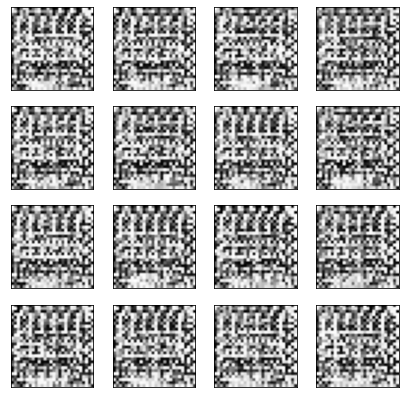

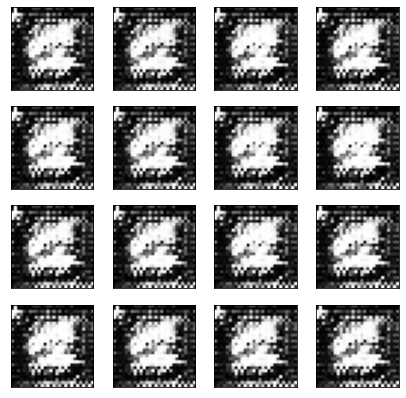

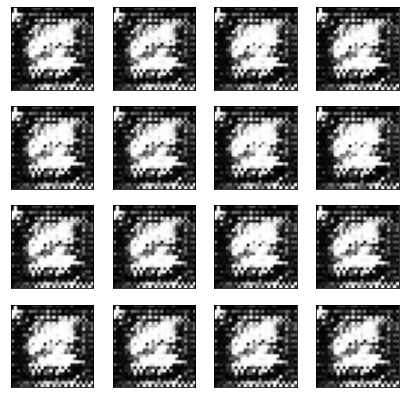

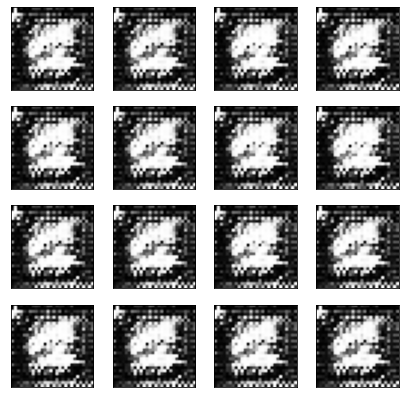

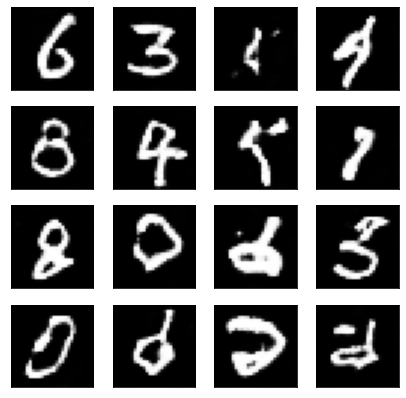

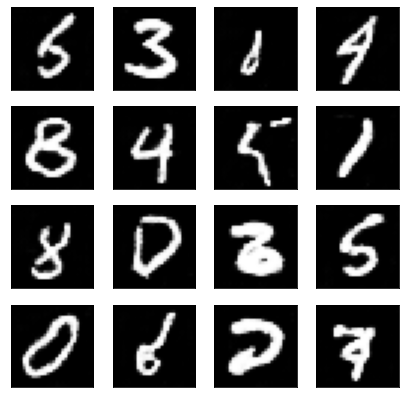

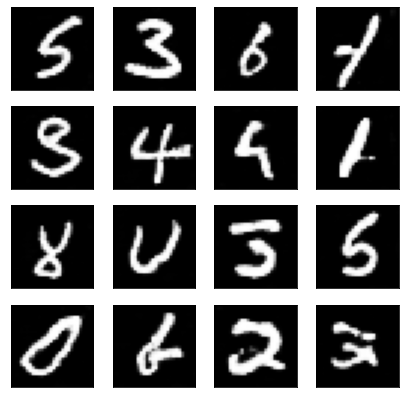

In [17]:
disc_losses, gen_losses = train(D, G, disc_opt, gen_opt, dataloader, batch_size)